In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
import random

In [ ]:
random.seed(42)

- user inputs their own parameters (means, variances within and between, expected ground truth correlation?, N they can afford) and then tool creates simulated data
- OR user inputs their data (task1_block1, task1_block2, task2_block1, etc) 
- tool delivers expected simulated naive correlation and corrected correlations with RMSE and CIs from bootstrap
- tool recommends estimator with least RMSE and has info about what might lead someone to want to apply the correction or not

## Functions for simulations

In [3]:
class def_variable_parameters:
    def __init__(self, betweenVar, withinVar, mean, learning_factor):
        self.ObsVar = betweenVar
        self.MeasVar = withinVar
        self.Mean = mean

In [4]:
def make_model_spec(n_meas):
    crowding_factor = "crowding_latent =~ " + " + ".join([f"crowding_measurement{i+1}" for i in range(n_meas)])
    rsvp_factor      = "rsvp_latent =~ " + " + ".join([f"rsvp_measurement{i+1}" for i in range(n_meas)])
    correlation_line = "crowding_latent ~~ rsvp_latent"
    return "\n".join([crowding_factor, rsvp_factor, correlation_line])

In [21]:
def simulate_data(x_params, y_params, n_samples=100, n_measurements=4, correlation = 0.6):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    The two required inputs are two objects, 
    each containing the parameters of the x and the y components of this correlation simulation.
     '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
        [correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_params.Mean, rsvp_params.Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise
        
        # Increase initial crowding thresholds by learning factor (since learning hasn't yet occurred)
        if i == 0:
            crowding_measurement += 2 * crowding_params.learning_factor
        if i == 1:
            crowding_measurement += crowding_params.learning_factor

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [24]:
def run_simulation(crowding_param, rsvp_param,
                   range_samples=(40, 80, 160, 320),
                   range_measurements=(2, 4, 8),
                   n_repetitions=500,
                   true_correlation=0.6):

    # ------------- containers ----------------------------------------
    hist_measured_corr, hist_rceiling_corr = {}, {}
    results_corr = []

    # ------------- main loops ----------------------------------------
    for n_samples in range_samples:
        for n_meas in range_measurements:

            list_measured, list_rceiling = [], []
            model_spec = make_model_spec(n_meas) 

            for _ in range(n_repetitions):

                # 1) --- simulate data --------------------------------
                sim = simulate_psychophysics_data(crowding_param, rsvp_param, n_samples, n_meas,
                                                  correlation=true_correlation)
                wMeans = sim['crowding_measurement']
                zMeans = sim['rsvp_measurement']

                # 2) --- raw correlation & noise ceiling --------------
                measured_corr, _ = pearsonr(wMeans, zMeans)

                W = sim[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                Z = sim[[f'rsvp_measurement{i+1}'     for i in range(n_meas)]]

                Rxx = compute_noise_ceiling(W)
                Ryy = compute_noise_ceiling(Z)
                lam = np.sqrt(Rxx * Ryy)

                rceiling_corr = measured_corr / lam
                
                # 3) --- stash ---------------------------------------
                list_measured.append(measured_corr)
                list_rceiling.append(rceiling_corr)

            # ----- save full histograms ------------------------------
            hist_measured_corr[(n_samples, n_meas)] = list_measured
            hist_rceiling_corr[(n_samples, n_meas)] = list_rceiling

            # ----- aggregated stats ----------------------------------
            def rmse(xs):
                return np.sqrt(np.mean((np.array(xs) - true_correlation)**2))

            results_corr.append({
                "n_samples":        n_samples,
                "n_measurements":   n_meas,

                "mean_measured":    np.mean(list_measured),
                "rmse_measured":    rmse(list_measured),
                "sd_measured":      np.std(list_measured),

                "mean_rceiling":    np.mean(list_rceiling),
                "rmse_rceiling":    rmse(list_rceiling),
                "sd_rceiling":      np.std(list_rceiling)
            })

        print(f"done with n_samples = {n_samples}")

    return (pd.DataFrame(results_corr),
            hist_measured_corr,
            hist_rceiling_corr)

## Functions for noise-correction

In [3]:
def compute_variances(data):
    '''
    takes in n x m dataframe representing n participants and m thresholds (log units)
    
    returns within-participant and across-participant variances
    '''
    
    # Noise: variance within individuals
    within_indiv_var = np.mean(np.var(data, axis = 1, ddof=1))

    # Signal: variance across individuals
    across_indiv_var = np.var(np.mean(data, axis = 1), ddof=1)
    
    return within_indiv_var, across_indiv_var

In [4]:
def compute_noise_ceiling_splitHalf(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_i, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Apply the extrapolation formula for multiple measurements (2 halves)
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

In [23]:
def compute_noise_ceiling(measurements: pd.DataFrame) -> float:
    """
    measurements: DataFrame of shape (n_observers, n_repeats),
                  each column is one repeated threshold per observer.
    Returns the reliability R = Var(means) / [Var(means) + Var_within/k].
    """
    k = measurements.shape[1]
    # between‑observer variance of the k‑repeat means
    means = measurements.mean(axis=1)
    between_var = means.var(ddof=1)
    # average within‑observer variance
    within_var = measurements.var(axis=1, ddof=1).mean()
    # reliability of the mean of k repeats
    return between_var / (between_var + within_var / k)

In [ ]:
def calc_within_subj_variance(df, task_prefix):
    """Calculate within-subject variance for all subjects for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Calculate variance for each subject (row) across repeats (columns)
    return df[task_cols].var(axis=1, ddof=1).mean()

def calc_between_subj_variance(df, task_prefix):
    """Calculate between-subject variance for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # Variance between subjects
    return np.nanvar(subj_means, ddof=1)

def calc_mean(df, task_prefix):
    """Calculate mean for all thresholds for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # first average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # then average across subjects
    return np.nanmean(subj_means)

def compute_noise_ceiling(df, task_prefix):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	measurements = df[task_cols]

	n_measurements = measurements.shape[1]
	
	first_half = measurements.iloc[:, :n_measurements//2]
	last_half = measurements.iloc[:, n_measurements//2:]
	odd_half = measurements.iloc[:, 1::2]
	even_half = measurements.iloc[:, 0::2]
	
	# Compute means while ignoring NaN
	mean_first_half = np.mean(first_half, axis=1)
	mean_last_half = np.mean(last_half, axis=1)

	# Filter out rows where either mean is NaN
	valid_indices = ~np.isnan(mean_first_half) & ~np.isnan(mean_last_half)

	# Compute Pearson correlation only for valid rows
	r_firstLast, _ = pearsonr(mean_first_half[valid_indices], mean_last_half[valid_indices])

	# Repeat for odd/even halves
	mean_odd_half = np.mean(odd_half, axis=1)
	mean_even_half = np.mean(even_half, axis=1)

     
	valid_indices = ~np.isnan(mean_odd_half) & ~np.isnan(mean_even_half)
	r_oddEven, _ = pearsonr(mean_odd_half[valid_indices], mean_even_half[valid_indices])
	
	# Compute the split-half reliability as the geometric mean
	r_i = np.sqrt(r_firstLast * r_oddEven)

	# Apply the extrapolation formula for multiple measurements
	N = 2
	r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

	return r_m


def gather_results(df, task_prefixes):
    """Gather results for within and between subject variance."""
    results = []
    for task in task_prefixes:
        within_var = calc_within_subj_variance(df, task)
        between_var = calc_between_subj_variance(df, task)
        mean_val = calc_mean(df, task)
        r_ceiling = compute_noise_ceiling(df, task)
        
        results.append({'task': task, 'within_subj_variance': within_var, 
                        'btw_subj_variance': between_var, 'mean': mean_val,
                        'r_ceiling': r_ceiling})
    return pd.DataFrame(results)

## Functions for plotting the results

In [31]:
def plot_measured_rceiling_mmse(results_corr_df, 
                               x_values, x_subset_name,
                               line_values, line_subset_name, line_label,
                               y_measured_name, y_rceiling_name, #y_mmse_name,
                               x_label, y_label, colors,
                               y_lim=(-0.02, 0.25), true_correlation=0.6):
    """
    Plots three correlation metrics:
      - y_measured_name:   "Measured" (uncorrected)
      - y_rceiling_name:   "R-ceiling" corrected
      - y_mmse_name:        "mmse" latent correlation

    :param results_corr_df:   DataFrame containing the data to plot
    :param x_values:          Distinct x-values (e.g. [2,4,8,16])
    :param x_subset_name:     Column name in df that matches x_values (e.g. 'n_measurements')
    :param line_values:       Distinct line values (e.g. sample sizes) for the plot
    :param line_subset_name:  Column name that matches line_values (e.g. 'n_samples')
    :param line_label:        Label for the legend title (e.g. 'Sample size')
    :param y_measured_name:   Column name for measured correlation metric
    :param y_rceiling_name:   Column name for r-ceiling correlation metric
    :param y_mmse_name:        Column name for mmse correlation metric
    :param x_label:           X-axis label
    :param y_label:           Y-axis label
    :param colors:            List/array of colors for each line
    :param y_lim:             Tuple specifying y-limit on the y-axis
    """

    plt.figure(figsize=(10, 6))

    for i, lv in enumerate(line_values):
        subset = results_corr_df[results_corr_df[line_subset_name] == lv]
        color  = colors[i]

        x = subset[x_subset_name].to_numpy()       
        y_meas = subset[y_measured_name].to_numpy()
        y_rc   = subset[y_rceiling_name].to_numpy()
        #y_mmse  = subset[y_mmse_name].to_numpy()

        plt.plot(x, y_meas, '-o',  color=color, label=f"{lv} (Raw)")
        plt.plot(x, y_rc,   '--o', color=color, label=f"{lv} (Unbiased)")
        #plt.plot(x, y_mmse,  '-.o', color=color, label=f"{lv} (mmse)")

    # Optional reference line
    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.axhline(true_correlation, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(y_lim)
    plt.yticks(size=14)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=14)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # Build unique legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # preserve order but remove duplicates
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    plt.legend(unique_handles, unique_labels, title=line_label,
               bbox_to_anchor=(1.05, 1), loc='upper left',
               title_fontsize=16, fontsize=14)

    plt.tight_layout()
    plt.show()

In [32]:
def plot_sim_results(results_corr_df, true_correlation=0.6):

    sample_sizes = sorted(results_corr_df["n_samples"].unique())
    colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))
    n_measurements = sorted(results_corr_df["n_measurements"].unique())

    # 1) RMSE
    plot_measured_rceiling_mmse(
        results_corr_df,
        x_values=n_measurements,
        x_subset_name='n_measurements',
        line_values=sample_sizes,
        line_subset_name='n_samples',
        line_label='Sample size',
        y_measured_name='rmse_measured',
        y_rceiling_name='rmse_rceiling',
        #y_mmse_name='rmse_mmse_corr',
        x_label='Number of measurements',
        y_label='RMSE',
        colors=colors,
        y_lim=(-0.02, 0.25),
        true_correlation=true_correlation
    )

    # 2) Mean difference
    plot_measured_rceiling_mmse(
        results_corr_df,
        x_values=n_measurements,
        x_subset_name='n_measurements',
        line_values=sample_sizes,
        line_subset_name='n_samples',
        line_label='Sample size',
        y_measured_name='mean_measured',
        y_rceiling_name='mean_rceiling',
        #y_mmse_name='mean_mmse_corr',
        x_label='Number of measurements',
        y_label='Mean',
        colors=colors,
        y_lim=(true_correlation-.2, true_correlation+.2),
        true_correlation=true_correlation
    )

    # 3) Standard Deviation
    plot_measured_rceiling_mmse(
        results_corr_df,
        x_values=n_measurements,
        x_subset_name='n_measurements',
        line_values=sample_sizes,
        line_subset_name='n_samples',
        line_label='Sample size',
        y_measured_name='sd_measured',
        y_rceiling_name='sd_rceiling',
       # y_mmse_name='sd_mmse_corr',
        x_label='Number of measurements',
        y_label='SD',
        colors=colors,
        y_lim=(-0.02, 0.25),
        true_correlation=true_correlation
    )

In [27]:
def plot_histograms(hist_corr, corr_type="Uncorrected"):
    """
    Plots histograms of differences in correlation values for different sample and measurement conditions.
    
    Parameters:
    hist_corr (dict): A dictionary where keys are tuples (n_samples, n_measurements),
                      and values are lists/arrays of differences.
    corr_type (str): either "Uncorrected" or "Corrected"
    """
    for (n_samples, n_measurements), differences in hist_corr.items():
        mean_diff = np.mean(differences)
        sd = np.std(differences)

        fig, ax = plt.subplots(figsize=(5, 4))
        ax.hist(differences, bins=20, alpha=0.7, edgecolor='black')

        # Add vertical lines for mean and standard deviation
        ax.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2)
        ax.axvline(0.6, color='black', linestyle='dashed', linewidth=3)

        # Text relative to axis coordinates (0 to 1 range)
        ax.text(0.69, 0.92, 'ground truth', transform=ax.transAxes, fontsize=11, color='black')
        ax.text(mean_diff-.07, 0.92, 'mean', transform=ax.transAxes, fontsize=11, color='red')

        # Formatting
        ax.set_xlim(-0.2, 1)
        ax.set_ylim(0, 190)
        ax.set_xlabel(f"{corr_type}-Sample R")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Samples={n_samples}, Measurements={n_measurements}")
        plt.tight_layout()
        plt.show()

        print(f"Mean difference: {0.6-mean_diff:.3f}")

In [28]:
crowding_param = def_variable_parameters(betweenVar = betweenVar_logCrowding_original, 
                                         withinVar = withinVar_logCrowding_original, 
                                         mean = mean_logCrowding, 
                                         learning_factor = 0)

rsvp_param = def_variable_parameters(betweenVar = betweenVar_logRSVP, 
                                     withinVar = withinVar_logRSVP, 
                                     mean = mean_logRSVP, 
                                     learning_factor = 0)

In [29]:
# Run simulation
results_corr_df, hist_measured_corr, hist_ceiling_corr = run_simulation(crowding_param, rsvp_param,
                   range_samples=(40, 80, 160, 320),
                   range_measurements=(2, 4, 8, 16),
                   n_repetitions=1000,
                   true_correlation=0.6)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


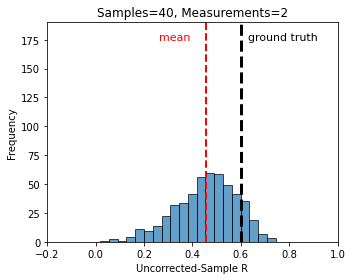

Mean difference: 0.144


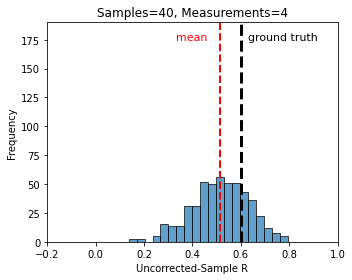

Mean difference: 0.086


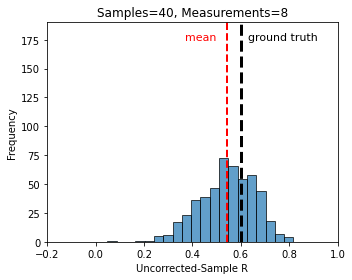

Mean difference: 0.057


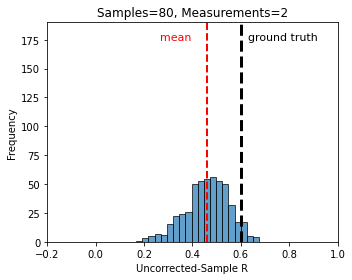

Mean difference: 0.141


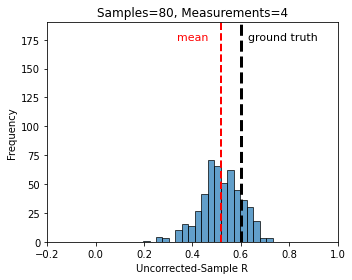

Mean difference: 0.083


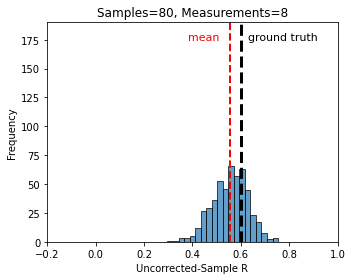

Mean difference: 0.045


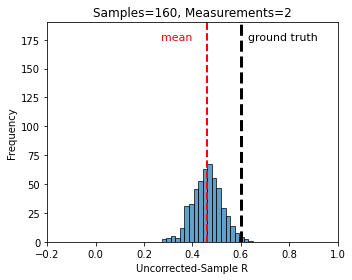

Mean difference: 0.140


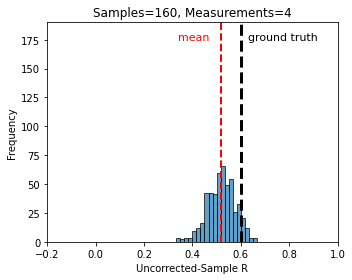

Mean difference: 0.081


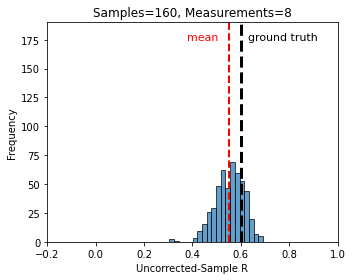

Mean difference: 0.047


In [138]:
plot_histograms(hist_measured_corr, corr_type = "Uncorrected")

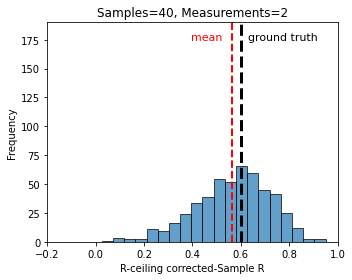

Mean difference: 0.035


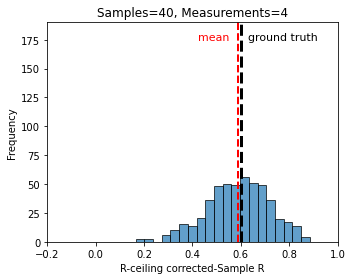

Mean difference: 0.013


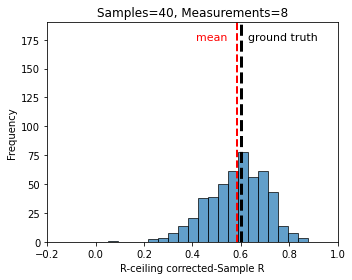

Mean difference: 0.016


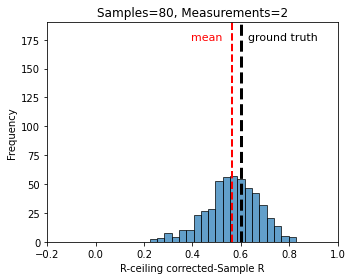

Mean difference: 0.036


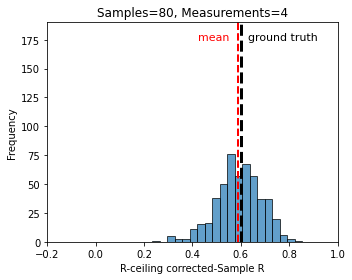

Mean difference: 0.010


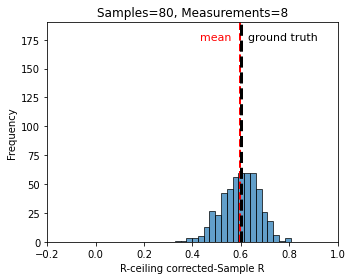

Mean difference: 0.003


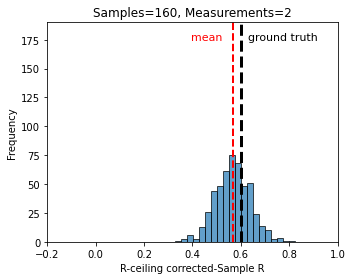

Mean difference: 0.033


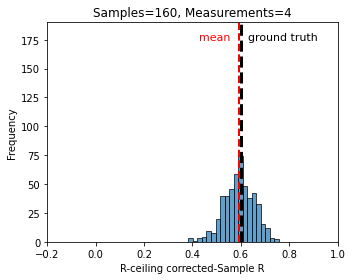

Mean difference: 0.009


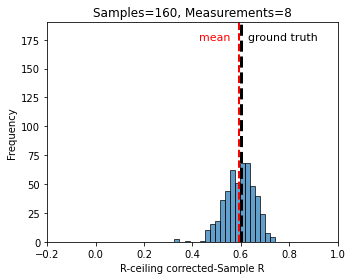

Mean difference: 0.006


In [139]:
plot_histograms(hist_ceiling_corr, corr_type = "R-ceiling corrected")

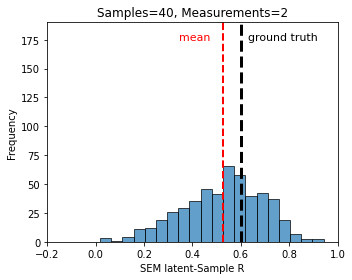

Mean difference: 0.075


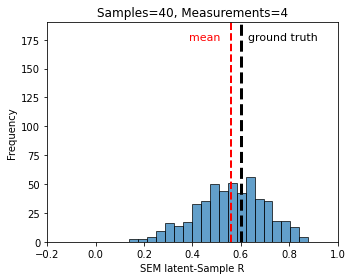

Mean difference: 0.042


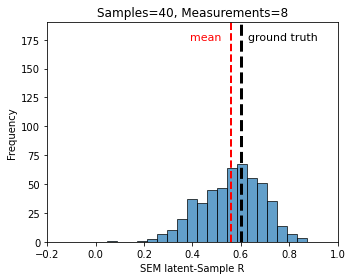

Mean difference: 0.039


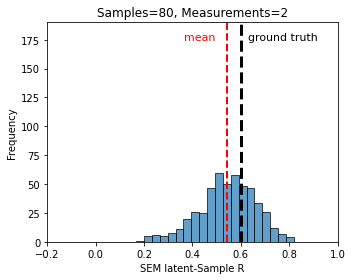

Mean difference: 0.057


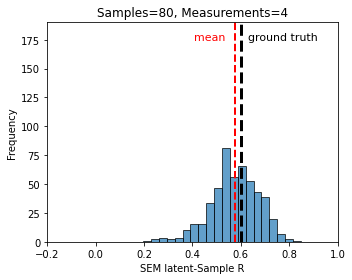

Mean difference: 0.025


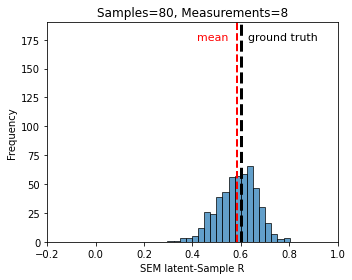

Mean difference: 0.015


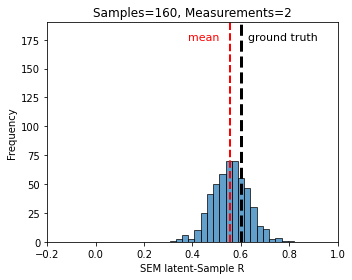

Mean difference: 0.044


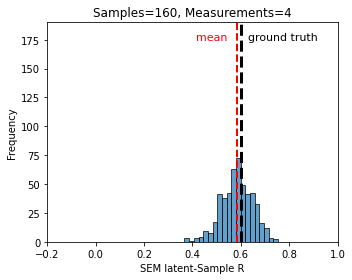

Mean difference: 0.016


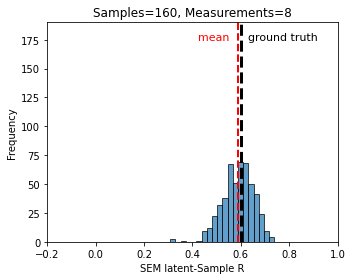

Mean difference: 0.012


In [140]:
plot_histograms(hist_mmse_corr, corr_type = "SEM latent")

## mean-variance

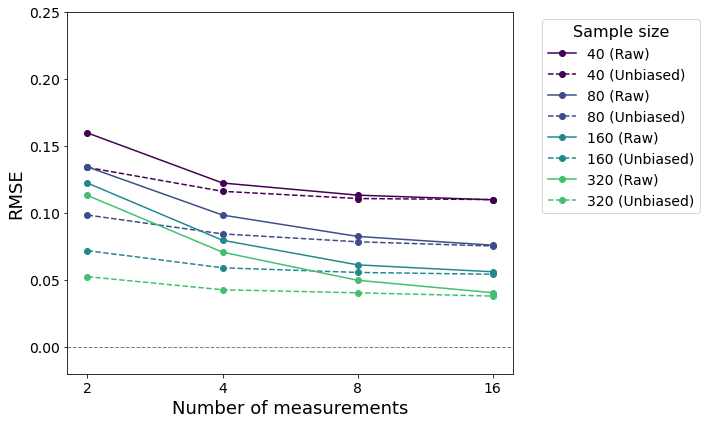

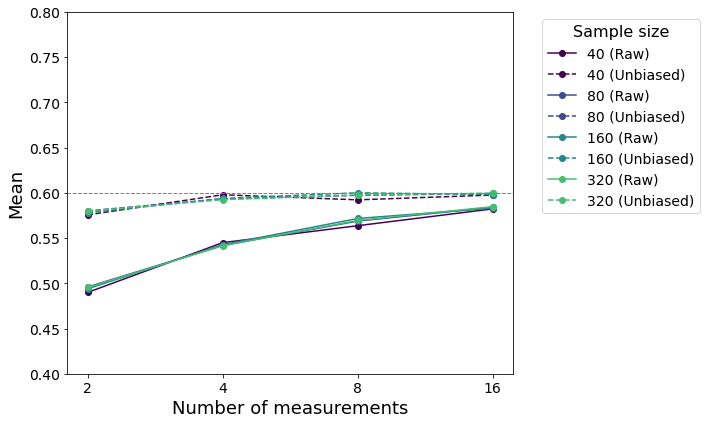

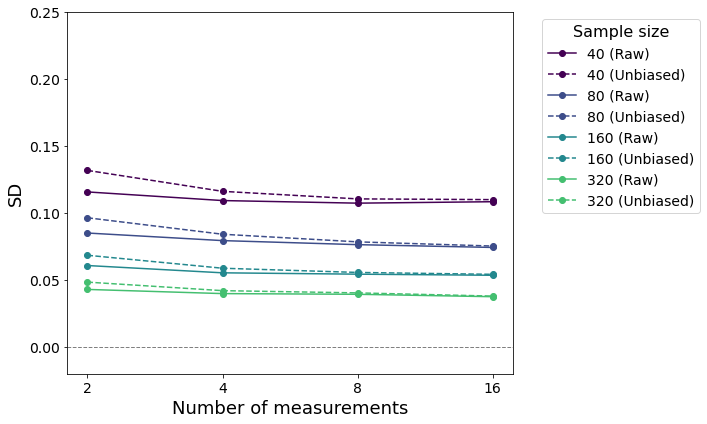

In [33]:
plot_sim_results(results_corr_df, true_correlation=0.6)